# Structured RerF Demo: Impulse Response
We form a two-class classification problem where each data point is 100 timesteps. Class 0 is simply white noise while class 1 is white noise plus an exponentially decaying unit impulse beginning at timestep 20.

We test the performance of S-Rerf and a set of other classification algorithms, training each on samples of sizes $n \in \{50,100,200,400,1000,2000\}$, each containing an equal number of data points in each class. The average 0-1 loss is evaluated for each algorithm for each training size using a single test set of size $m=10000$ with an equal number of data points in each class.

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from rerf.rerfClassifier import rerfClassifier

import warnings
warnings.simplefilter('ignore')

In [3]:
def samp(n, cls=0, separate=False):
    ## Sample n samples from either class 0 or 1
    ## Class 1 has the impulse added
    M0 = 20 # Onset of impulse response
    M1 = 100-M0
    func = lambda x: [np.exp(-0.1*(j-M0)) if j >= M0 else 0.0 for j in x] # Impulse response function
    if cls == 0:
        X = np.full((n,M0+M1),0.0)
        Y = np.full(n,cls)
    elif cls == 1:
        X = np.tile(func(np.arange(0,M0+M1)),reps=(n,1))
        Y = np.full(n,cls)
    
    if separate:
        # White noise
        noise = np.random.normal(0,1,size=(n,M0+M1))
        
        return(X,Y,noise)
    else:
        # White noise
        X += np.random.normal(0,1,size=(n,M0+M1))

        return(X,Y)

def mixed_samp(n0,n1,shuffle=True):
    ## Generate a collection of mixed class (shuffled) observations
    X0,Y0 = samp(n0,cls=0)
    X1,Y1 = samp(n1,cls=1)
    X = np.vstack([X0,X1])
    Y = np.hstack([Y0,Y1])
    if shuffle:
        shuffled_idx= list(range(n0+n1)); np.random.shuffle(shuffled_idx)
        X = X[shuffled_idx]
        Y = Y[shuffled_idx]
    return(X,Y)

In [4]:
np.random.seed(1234)
ns = np.array([10,50,100,200,400,1000,2000])
TRAIN_FRAC = 0.5
n0 = [int(i*TRAIN_FRAC) for i in ns]
n1 = n0

X_train, Y_train = np.empty(shape=(0,100)), np.empty(shape=(0))
for l0,l1 in zip(np.append(n0[0],np.diff(a=n0)),
                 np.append(n1[0],np.diff(a=n1))):
    x, y = mixed_samp(l0,l1)
    X_train = np.vstack((X_train, x))
    Y_train = np.hstack((Y_train, y))

TEST_SIZE = 10000
X_test, Y_test = mixed_samp(int(TEST_SIZE*0.5),int(TEST_SIZE*0.5))

In [5]:
fontsize = 9
sns.set(); sns.set(style="dark", 
                   rc={'font.size':fontsize, 
                     'legend.fontsize': fontsize,
                     'xtick.labelsize': fontsize,
                     'ytick.labelsize': fontsize,
                     'axes.labelsize': fontsize,
                     'axes.titlesize': fontsize})
#sns.set_style({'axes.grid' : False})
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

<Figure size 432x288 with 0 Axes>

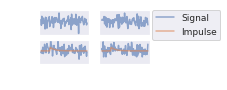

In [6]:
plt.clf()
np.random.seed(1234)
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(2,1))

X0, Y0 = samp(2,cls=0)
X1, Y1, noise = samp(2,cls=1, separate=True)

axes[0,0].plot(X0[0,:], alpha=0.6, label='Signal')
#axes[0,0].legend(loc='lower left',frameon=False)
axes[0,0].set_title("Class 0")
#axes[0,0].set_ylabel("Observed Values")

axes[0,1].plot(X0[1,:], alpha=0.6, label='Signal')
#axes[0,1].legend(loc='lower left',frameon=False)
axes[0,1].set_title("Class 0")

axes[1,0].plot(X1[0,:] + noise[0,:], label='Signal', alpha=0.6)
axes[1,0].plot(X1[0,:], label='Impulse', alpha=0.6)
#axes[1,0].legend(loc='lower left',frameon=False)
axes[1,0].set_title("Class 1")
#axes[1,0].set_xlabel("Timestep")
#axes[1,0].set_ylabel("Observed Values")

axes[1,1].plot(X1[1,:] + noise[1,:], label='Signal', alpha=0.6)
axes[1,1].plot(X1[1,:], label='Impulse', alpha=0.6)
#axes[1,1].legend(loc='lower left',frameon=False)
axes[1,1].set_title("Class 1")
#axes[1,1].set_xlabel("Timestep")

for idx1 in range(2):
    for idx2 in range(2):
        axes[idx1,idx2].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        axes[idx1,idx2].set_title('')

handles, labels = axes[1,1].get_legend_handles_labels()
lgd = axes[0,1].legend(handles, labels, loc='upper left',bbox_to_anchor = (1.04,1), borderaxespad=0)

bax = fig.add_subplot(111, frameon=False)

bax.grid(False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

#plt.ylabel('Signal Values')
#plt.xlabel('Timestep')

plt.tight_layout()
#fig.subplots_adjust(wspace=0.12)
plt.savefig('../impulse_sample_minimal.pdf',bbox_inches='tight',bbox_extra_artists=(lgd,), format='pdf')
plt.show()

In [4]:
## Setup for run
names = {"Log. Reg": "#a6cee3", 
         "Lin. SVM":"#1f78b4", 
         "SVM":"#b2df8a", 
         "kNN": "#33a02c", 
         "RF":"#fb9a99", 
         "MLP":"#fdbf6f", 
         "RerF":"#ff7f00", 
         "S-RerF":"#e31a1c",
         "CNN":"#cab2d6"}

ncores=1
num_runs=1
n_est=100

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=1000),
    rerfClassifier(n_estimators = n_est, projection_matrix = "RerF",
                    max_features = 'auto', n_jobs = ncores),
    rerfClassifier(projection_matrix="S-RerF",
                   max_features='auto',
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=1,
                    image_width=100,
                    patch_height_max=1,
                    patch_height_min=1,
                    patch_width_max=5,
                    patch_width_min=1
                   )
    ]

In [80]:
# Train each classifier on each dataset size, then test
## Prep output file:
f = open('s-rerf_impulse_experiment_rerf_1run.csv', 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()

runList = [(n, clf, run) for n in ns\
                       for clf in zip(classifiers, [key for key in names])\
                       for run in range(num_runs)]

for n, clf, iteration in tqdm(runList):
        X = X_train[:n]
        y = Y_train[:n]

        trainStartTime = time.time()
        clf[0].fit(X, y)
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        out = clf[0].predict(X_test)
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(out, Y_test).astype(int))


        ####("variable,Lhat,trainTime,testTime,iterate")
        f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
        f.flush()

f.close()

100%|██████████| 56/56 [00:48<00:00,  3.03s/it]


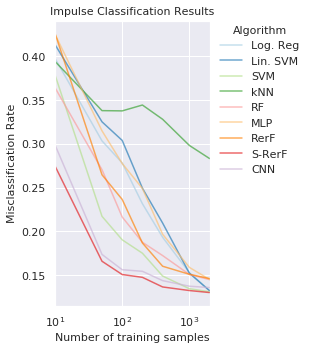

In [152]:
## Sklearn algos
dat = pd.read_csv("s-rerf_impulse_experiment_rerf_1run.csv")

#d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'se', 'color'])
d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        se = stats.sem(tmp['Lhat'])
        
        list(tmp.mean())
        #d1.loc[k] = [cl] + list(tmp.mean()) + [se] + [names[cl]]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1

## CNN ADDON
dat2 = pd.read_csv("impulse_cnn_results_5runs.csv")

for ni in np.unique(dat2['n']):
    for cl in np.unique(dat2['classifier']):
        if not cl in names.keys():
            continue
            
        tmp = dat2[np.logical_and(dat2['classifier'] == cl,dat2['n'] == ni)][['n', 'Lhat']]
        
        se = stats.sem(tmp['Lhat'])
        
        list(tmp.mean())
        #d1.loc[k] = [cl] + list(tmp.mean()) + [se] + [names[cl]]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1
        
## Plot

fontsize = 11

sns.set(); sns.set(style="darkgrid", rc={"font.size":fontsize,"axes.titlesize":fontsize,"axes.labelsize":fontsize})  
fig, ax = plt.subplots(figsize = (4.5,5))

for key in names.keys():
    grp = d1[d1['classifier'] == key] 
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    ax.set_xscale('log')

lgd = ax.legend(title='Algorithm', loc='upper left',bbox_to_anchor = (1.04,1), borderaxespad=0, frameon=False)#plt.legend(loc='upper right',title='Algorithm')
plt.title('Impulse Classification Results')
plt.ylabel('Misclassification Rate')
plt.xlabel('Number of training samples')
plt.tight_layout()
#plt.savefig('./s-rerf_impulse_experiment.pdf',format='pdf')
plt.show()

## CNN Classification

In [146]:
import torch
import torch.nn as nn
import torch.utils.data as utils
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [188]:
# Hyperparameters
num_epochs = 100
num_classes = 2
batch_size = 200
learning_rate = 0.001
num_cnn_runs = 5

In [189]:
tensor_x = torch.from_numpy(np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))).float()
tensor_y = torch.from_numpy(np.asarray(Y_test)).long()

test_tensor = utils.TensorDataset(tensor_x,tensor_y) # create your datset
test_loader = DataLoader(dataset=test_tensor, batch_size=batch_size, shuffle=False)

In [190]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=10, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=10, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(18 * 64, 500)
        self.fc2 = nn.Linear(500, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [191]:
def cnn_learn(n, model):
    ## Data loader
    batch_size = int(n)
    
    X = X_train[0:n, ::]
    Y = Y_train[0:n]
    
    tensor_x = torch.from_numpy(np.reshape(X,(X.shape[0],1,X.shape[1]))).float()
    tensor_y = torch.from_numpy(np.asanyarray(Y)).long()

    train_tensor = utils.TensorDataset(tensor_x,tensor_y) # create your datset

    train_loader = DataLoader(dataset=train_tensor, batch_size=batch_size, shuffle=True)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    trainStartTime = time.time()
    
    total_step = len(train_loader)
    loss_list = []
    acc_list = []

    prior_loss = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            #images = images.float(); labels = labels.long()
            # Run the forward pass
            outputs = model(images.float())
            loss = criterion(outputs, labels.long())
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)
            curr_loss = loss.item()
            if ((i + 1) % 1 == 0) and ((epoch + 1) % 5 == 0):
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, curr_loss,
                              (correct / total) * 100))
        if epoch > 10:
            if stats.sem(prior_loss[-5:]) < 0.001:
                break
        prior_loss.append(loss.item())
    
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime
    
    # Test the model
    testStartTime = time.time()
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        testEndTime = time.time()
        testTime = testEndTime - testStartTime
        print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))
        
        lhat = 1- correct / total

        ####("variable,Lhat,trainTime,testTime,iterate")
        clf = "CNN"; iterate = 1
        
        return((clf,n,lhat,trainTime,testTime,iterate))

In [192]:
## Log output
np.random.seed(1234)

write_path = 'impulse_cnn_results_5runs.csv'

with open(write_path, 'w') as f:
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
    
runList = [(n, iterate) for n in ns\
                        for iterate in range(1, num_cnn_runs + 1)]

for n, iterate in runList:
    print(f"Size={n}, Iterate {iterate}")
    model = ConvNet()
    clf,n,lhat,trainTime,testTime,iterate = cnn_learn(n, model)
    
    with open(write_path, 'a') as f:
        f.write(f"{clf}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iterate}\n")

Size=10, Iterate 1
Epoch [5/100], Step [1/1], Loss: 0.1941, Accuracy: 100.00%
Epoch [10/100], Step [1/1], Loss: 0.0115, Accuracy: 100.00%
Epoch [15/100], Step [1/1], Loss: 0.0004, Accuracy: 100.00%
Test Accuracy of the model on the test images: 66.88 %
Size=10, Iterate 2
Epoch [5/100], Step [1/1], Loss: 0.1623, Accuracy: 100.00%
Epoch [10/100], Step [1/1], Loss: 0.0150, Accuracy: 100.00%
Epoch [15/100], Step [1/1], Loss: 0.0038, Accuracy: 100.00%
Test Accuracy of the model on the test images: 65.02 %
Size=10, Iterate 3
Epoch [5/100], Step [1/1], Loss: 0.1519, Accuracy: 100.00%
Epoch [10/100], Step [1/1], Loss: 0.0077, Accuracy: 100.00%
Epoch [15/100], Step [1/1], Loss: 0.0023, Accuracy: 100.00%
Epoch [20/100], Step [1/1], Loss: 0.0028, Accuracy: 100.00%
Epoch [25/100], Step [1/1], Loss: 0.0001, Accuracy: 100.00%
Test Accuracy of the model on the test images: 76.34 %
Size=10, Iterate 4
Epoch [5/100], Step [1/1], Loss: 0.1591, Accuracy: 100.00%
Epoch [10/100], Step [1/1], Loss: 0.0085, A